# Test PDPbox with Regression problem
## Kaggle Rossmann store with RandomForest regressor
This demo is based on **Rossmann Store Sales**  
https://www.kaggle.com/c/otto-group-product-classification-challenge

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

### read dataset

In [2]:
ross = pd.read_csv('rossmann_train.csv')
store = pd.read_csv('rossmann_store.csv')

C:\Users\jiangchun.li.ext.AXA-DIL\AppData\Local\Continuum\anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### simple feature engineering

In [3]:
ross = ross[ross['Open'] != 0]
ross = ross.merge(store, on='Store', how='left')

In [4]:
ross['Date'] = pd.to_datetime(ross['Date'])
ross['year'] = ross.Date.apply(lambda x : x.year)
ross['month'] = ross.Date.apply(lambda x : x.month)
ross['weekofyear'] = ross.Date.apply(lambda x: x.weekofyear)
ross.drop(['Date'], axis=1, inplace=True)

In [5]:
ross = pd.get_dummies(ross, columns=['StateHoliday', 'StoreType', 'Assortment'])

In [6]:
ross_features = ['DayOfWeek', 'SchoolHoliday', 'month', 'weekofyear', 'StateHoliday_a', 'StateHoliday_b',
                 'StateHoliday_c', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', 
                 'Assortment_a', 'Assortment_b','Assortment_c']

## RandomForestRegressor with PDPbox
### build model

In [7]:
from sklearn.ensemble import RandomForestRegressor

In [8]:
rf = RandomForestRegressor(n_estimators = 50, n_jobs=4)
%time rf.fit(ross[ross_features], ross['Sales'])

Wall time: 35.4 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

## start testing PDPbox

In [10]:
from pdpbox import pdp

### add target plot for SchoolHoliday

In [11]:
from pdpbox import info_plots

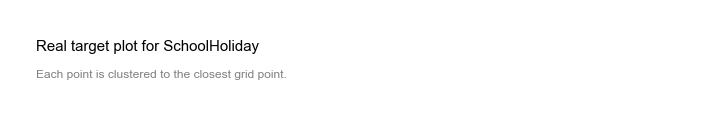

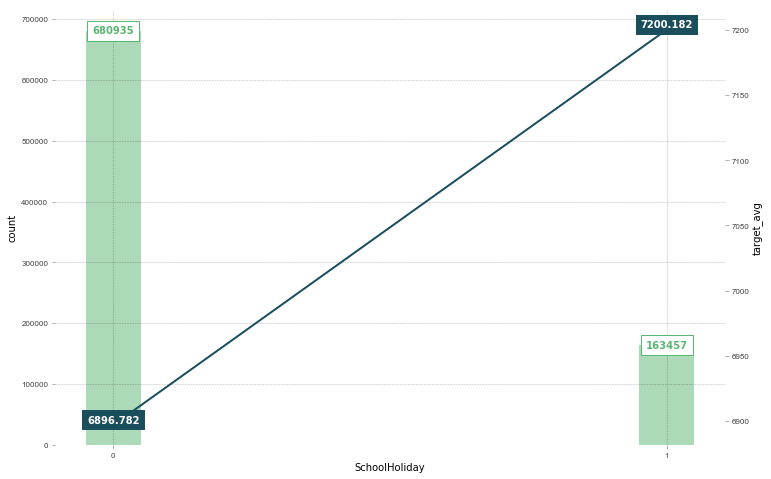

In [13]:
info_plots.target_plot(ross, 'SchoolHoliday', 'SchoolHoliday', 'Sales', figsize=(12, 8))

## binary feature: SchoolHoliday

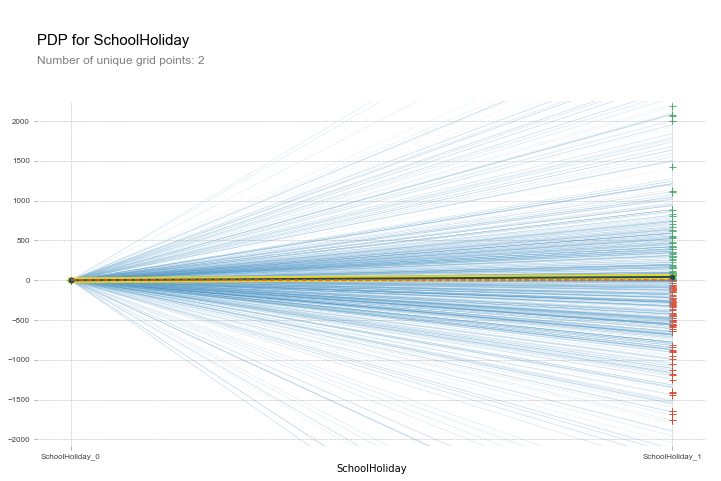

In [14]:
pdp_SchoolHoliday = pdp.pdp_isolate(rf, ross[ross_features], 'SchoolHoliday')
pdp.pdp_plot(pdp_SchoolHoliday, 'SchoolHoliday', plot_org_pts=True, plot_lines=True, frac_to_plot=1000, figsize=(12, 8))

#### really hard to tell the difference without centering the individual lines

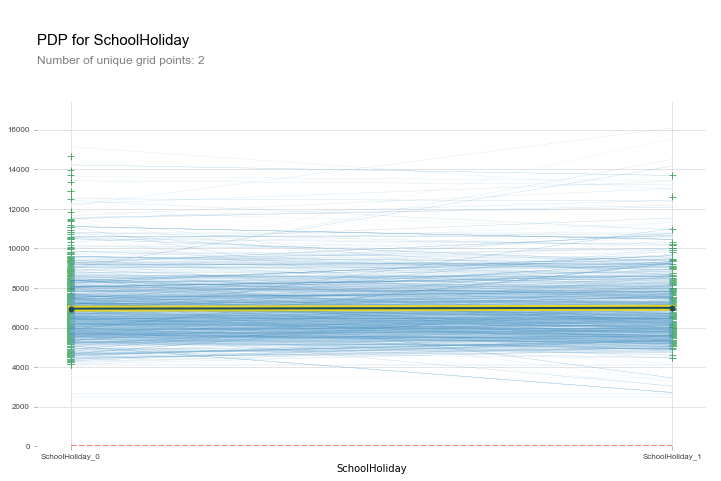

In [15]:
pdp.pdp_plot(pdp_SchoolHoliday, 'SchoolHoliday', plot_org_pts=True, plot_lines=True, frac_to_plot=1000, center=False, figsize=(12, 8))

#### cluster the individual lines

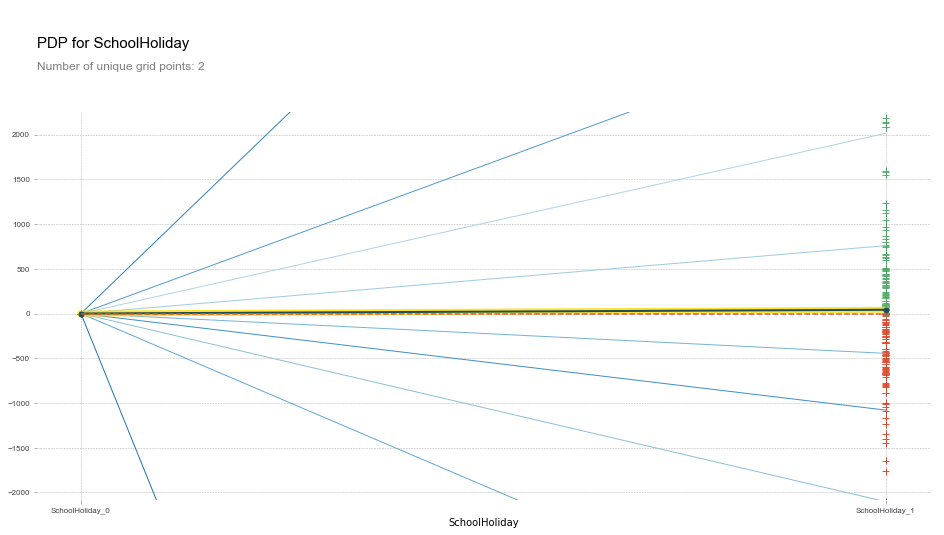

In [16]:
pdp.pdp_plot(pdp_SchoolHoliday, 'SchoolHoliday', plot_org_pts=True, plot_lines=True, frac_to_plot=1000, cluster=True, n_cluster_centers=10)

#### try to plot out the actual predictions

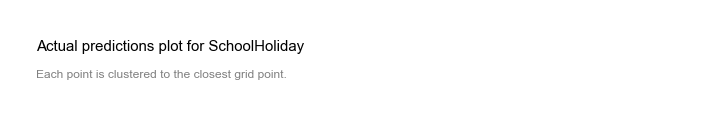

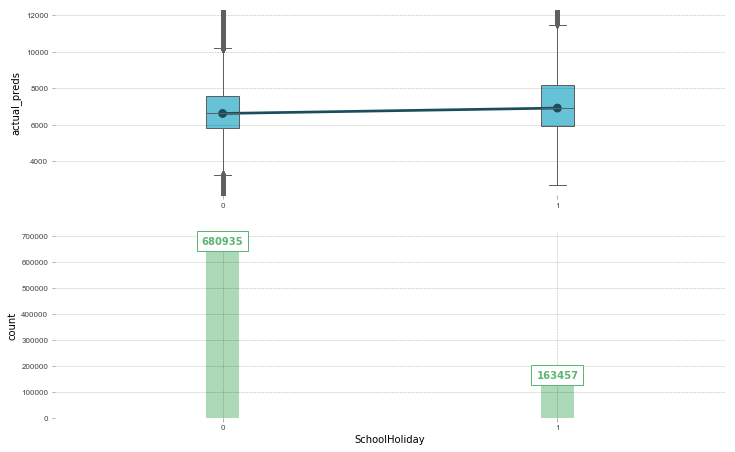

In [17]:
info_plots.actual_plot(pdp_SchoolHoliday, 'SchoolHoliday', figsize=(12, 8))

#### try to customize the actual plot

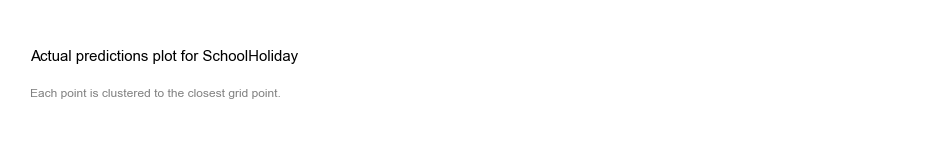

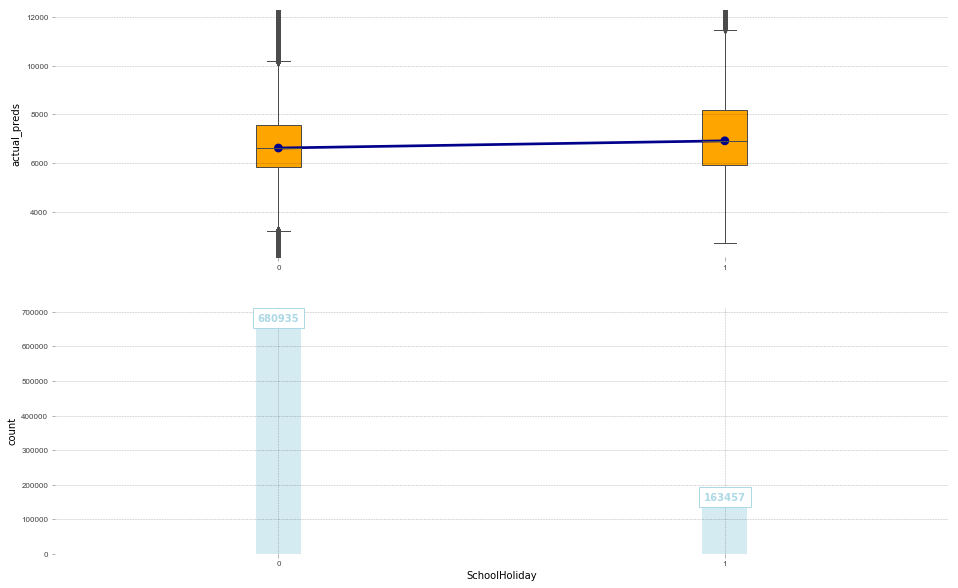

In [19]:
plot_params = {
    'boxcolor': 'orange',
    'linecolor': 'darkblue',
    'barcolor': 'lightblue'
}
info_plots.actual_plot(pdp_SchoolHoliday, 'SchoolHoliday', plot_params=plot_params)

## onehot encoding feature: StoreType

### add target plot for StoreType

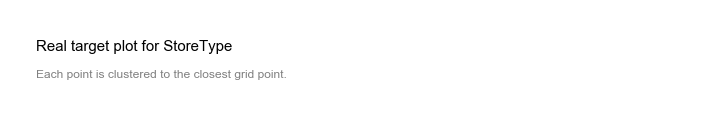

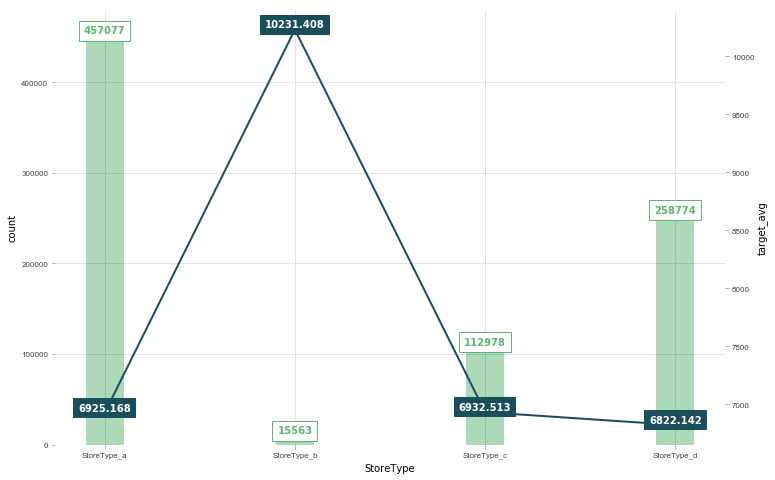

In [21]:
info_plots.target_plot(ross, ['StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d'], 'StoreType', 'Sales', figsize=(12, 8))

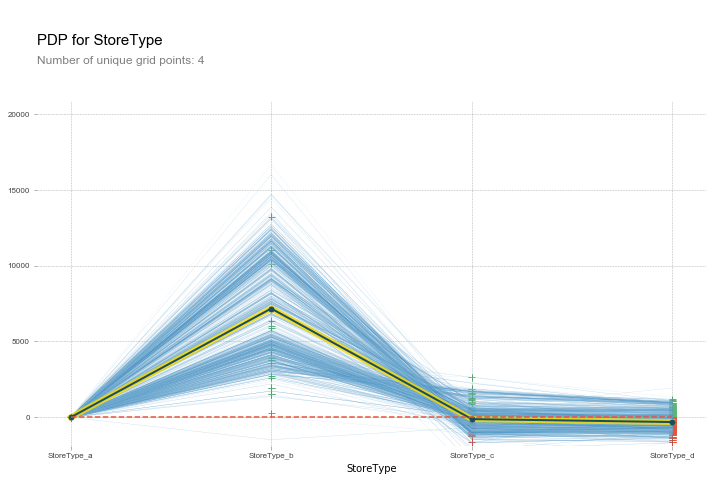

In [22]:
pdp_StoreType = pdp.pdp_isolate(rf, ross[ross_features], ['StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d'])
pdp.pdp_plot(pdp_StoreType, 'StoreType', plot_org_pts=True, plot_lines=True, frac_to_plot=1000, figsize=(12, 8))

#### try to plot out the actual predictions

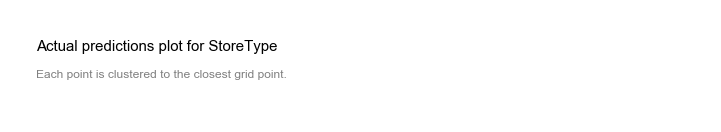

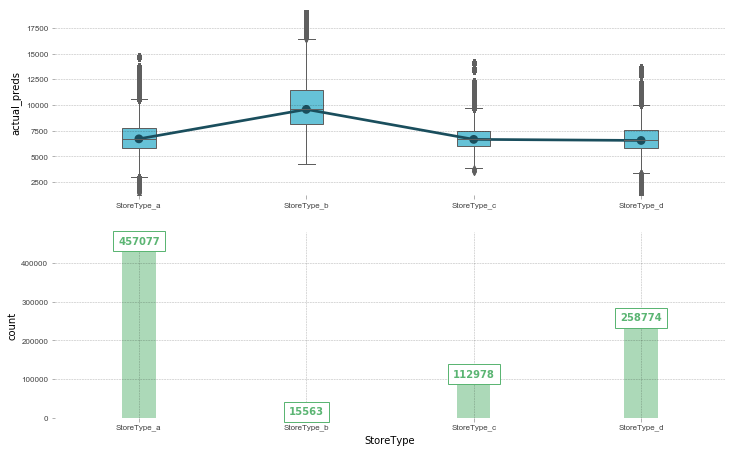

In [23]:
info_plots.actual_plot(pdp_StoreType, 'StoreType', figsize=(12, 8))

## numeric feature: weekofyear

### add target plot for weekofyear

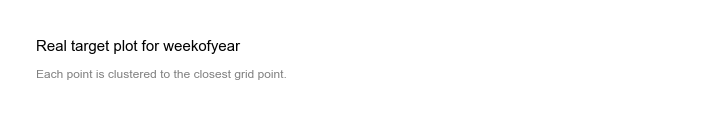

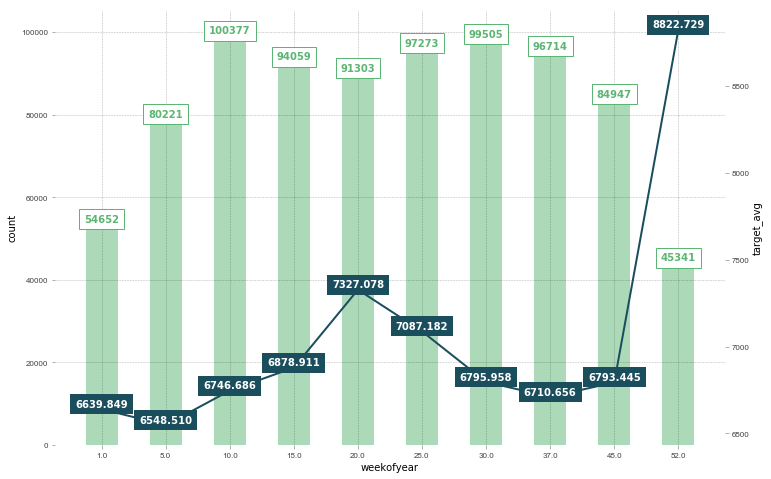

In [24]:
info_plots.target_plot(ross, 'weekofyear', 'weekofyear', 'Sales', figsize=(12, 8))

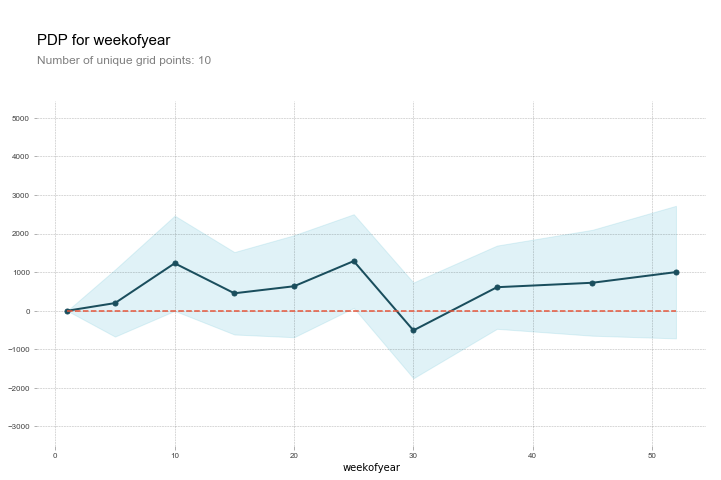

In [25]:
pdp_weekofyear = pdp.pdp_isolate(rf, ross[ross_features], 'weekofyear')
pdp.pdp_plot(pdp_weekofyear, 'weekofyear', figsize=(12, 8))

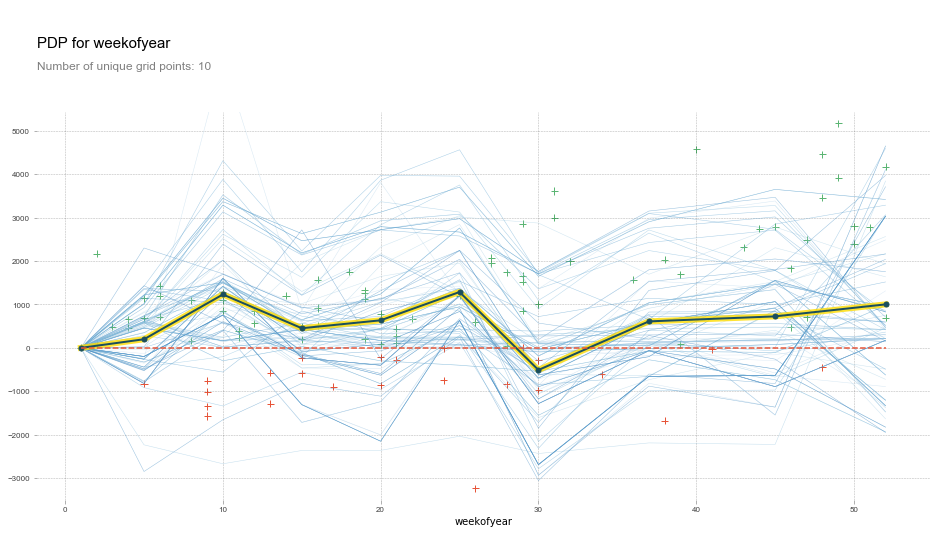

In [26]:
pdp.pdp_plot(pdp_weekofyear, 'weekofyear', plot_org_pts=True, plot_lines=True, frac_to_plot=100)

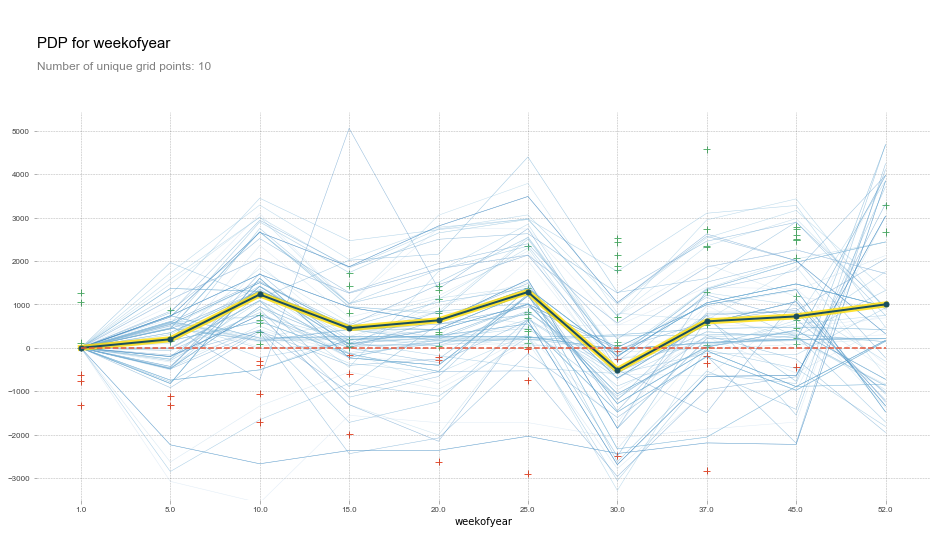

In [27]:
pdp.pdp_plot(pdp_weekofyear, 'weekofyear', plot_org_pts=True, plot_lines=True, frac_to_plot=100, x_quantile=True)

#### try to plot out the actual predictions

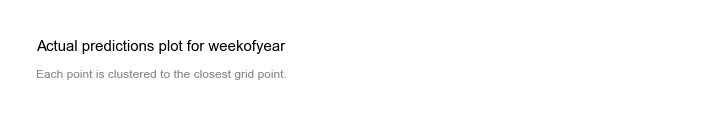

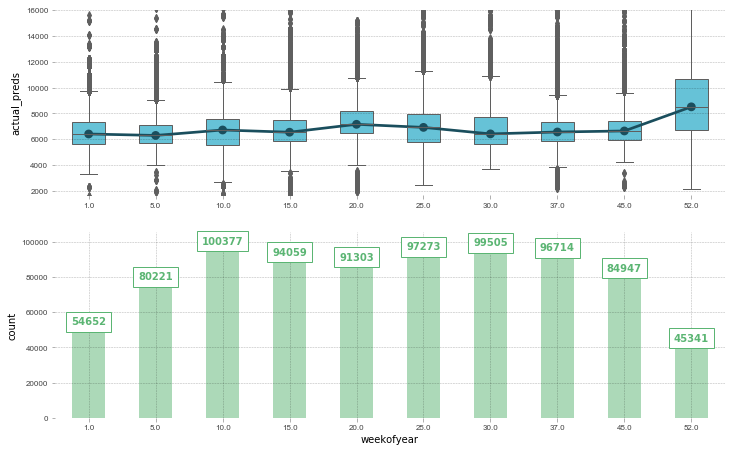

In [28]:
info_plots.actual_plot(pdp_weekofyear, 'weekofyear', figsize=(12, 8))

#### test customized grid points

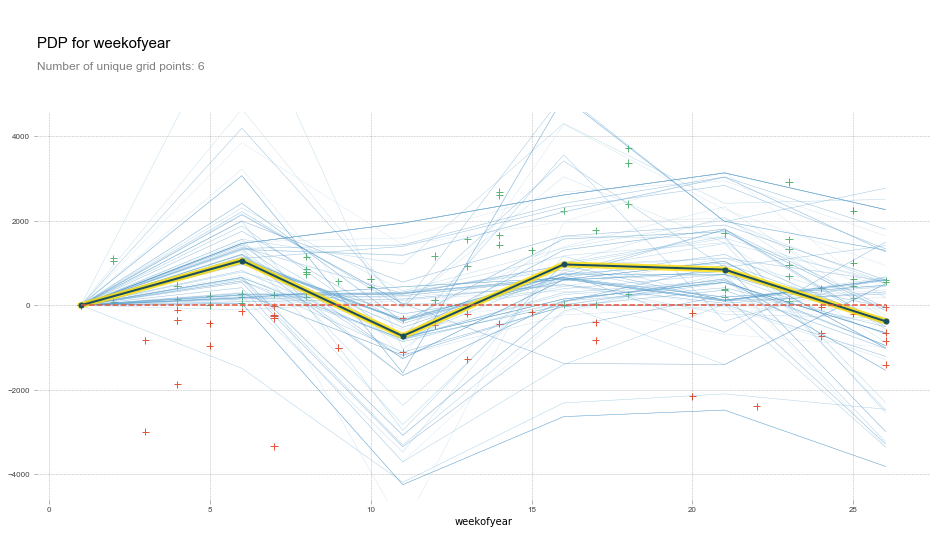

In [29]:
pdp_weekofyear = pdp.pdp_isolate(rf, ross[ross_features], 'weekofyear', cust_grid_points=range(1, 30, 5))
pdp.pdp_plot(pdp_weekofyear, 'weekofyear', plot_org_pts=True, plot_lines=True, frac_to_plot=100)

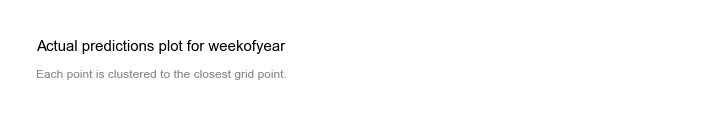

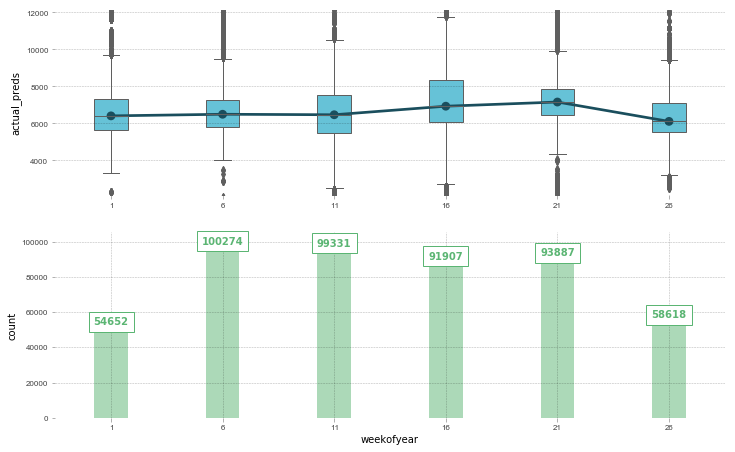

In [31]:
info_plots.actual_plot(pdp_weekofyear, 'weekofyear', figsize=(12, 8))

## test interaction

#### interaction between StoreType and weekofyear

In [32]:
inter_rf = pdp.pdp_interact(rf, ross[ross_features], 
                            [['StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d'], 'weekofyear'], 
                            num_grid_points=[10, 10])

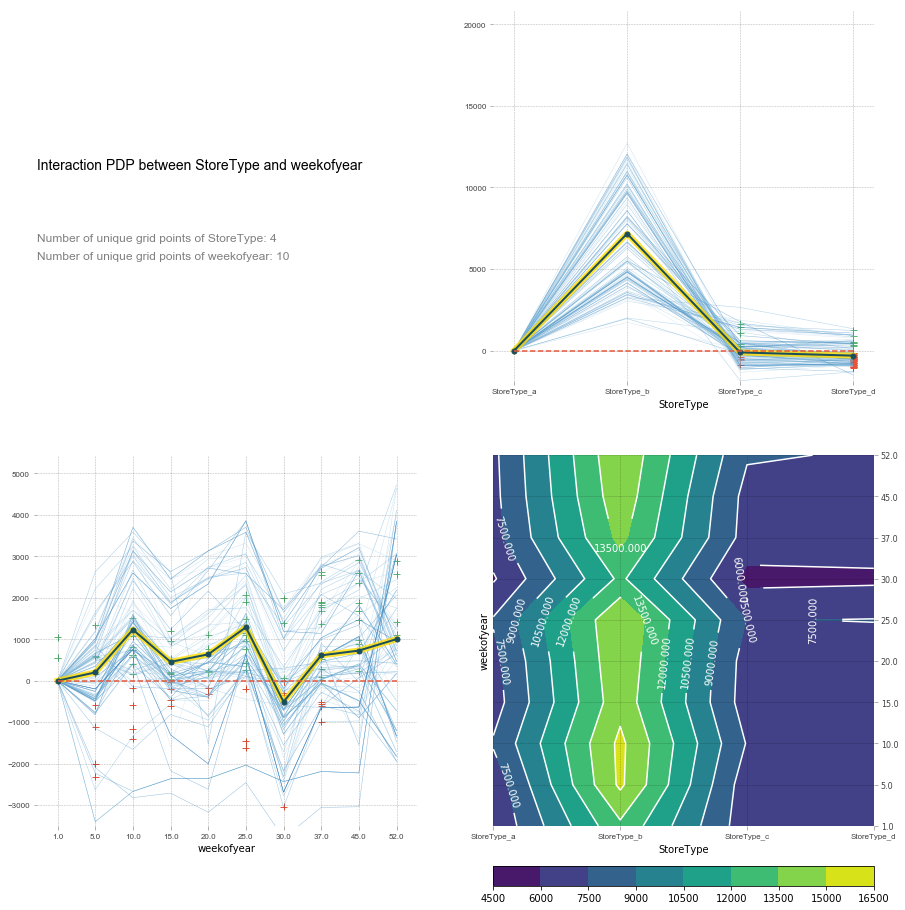

In [35]:
pdp.pdp_interact_plot(inter_rf, ['StoreType', 'weekofyear'], plot_org_pts=True, plot_lines=True, frac_to_plot=100, x_quantile=True)

#### only contours

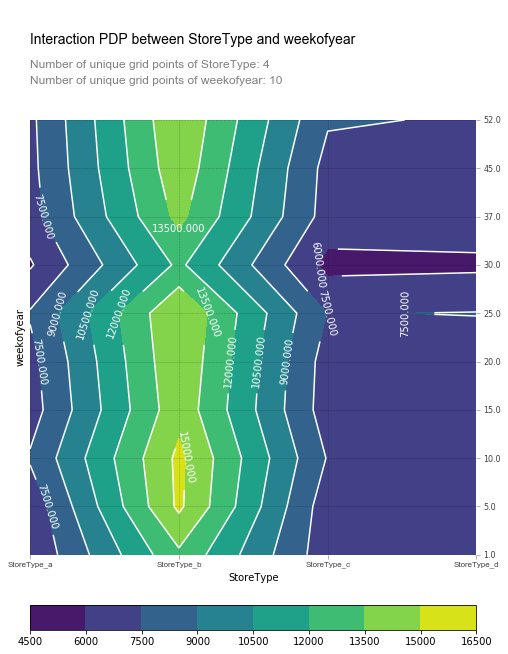

In [34]:
pdp.pdp_interact_plot(inter_rf, ['StoreType', 'weekofyear'], plot_org_pts=True, plot_lines=True, 
                      frac_to_plot=1000, x_quantile=True, only_inter=True)